# Projet MMMI : Rida ADARDOUR - Pays: Denmark

## Introduction

Le Danemark est un pays scandinave comptant environ 5,8 millions d'habitants. Le pays a connu son premier confinement de mars à juin 2020. En septembre 2020, une deuxième vague de coronavirus a frappé le pays, entraînant un deuxième confinement à partir de décembre 2020.

Ce projet vise à étudier l'évolution de la Covid-19 au Danemark entre le 1\textsuperscript{er} Novembre 2020 et le 31 Mars 2021, englobant ainsi la période de la deuxième vague. Nous allons développer un modèle épidémiologique complexifié pour mieux comprendre l'évolution de la maladie. Ce modèle servira d'outil prédictif pour anticiper la propagation de la maladie et pour soutenir les décisions politiques.

Nous allons également développer un modèle par classes d'âge afin d'analyser plus précisément l'impact de la maladie dans toutes les catégories d'âge de la population.


## Analyse de l'évolution du Covid au Denmark entre 01 Novembre 2020 et 31 Mars 2021

## Importer les librairies et les packages nécessaires

In [566]:
import arviz as az
import numpy as np

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter    

import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt

from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.10.4


## Importer le jeu de données covid du Danemark

In [567]:
import pandas as pd
data = pd.read_csv("covid19-data-denmark.csv")
data

,day,date,tests_accum,tests_today,tested_accum,tested_today,infected_accum,infected_today,dead_accum,dead_today,recovered_accum,recovered_today,active,hospitalized_now,hospitalized_change,hospitalized_admitted,icu_now,icu_change,respirator_now,respirator_change
0,0,2020-02-24,20,0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0.0
1,1,2020-02-25,9,-11,21.0,21.0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0.0
2,2,2020-02-26,19,10,31.0,10.0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0.0
3,3,2020-02-27,49,30,62.0,31.0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0,0.0
4,4,2020-02-28,158,109,173.0,111.0,1,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,1200,2023-06-08,67825644,614,NaN,NaN,3413947,25,8727,4,3182366,41,100,110,-12.0,19,3,NaN,0,NaN
1201,1201,2023-06-09,67826332,688,NaN,NaN,3413983,36,8729,2,3182405,39,100,107,-3.0,18,2,NaN,0,NaN
1202,1202,2023-06-10,67826834,502,NaN,NaN,3414007,24,8730,1,3182437,32,103,103,-4.0,18,4,NaN,1,NaN
1203,1203,2023-06-11,67827161,327,NaN,NaN,3414026,19,8732,2,3182464,27,104,102,-1.0,18,4,NaN,1,NaN


## Extraire les données covid de la période entre Novembre 2020 et Avril 2021

In [568]:


data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month


data1 = data.loc[(data['year']==2020)]
data2 = data.loc[(data['year']==2021)]

data3 = data1.loc[(data['month']>10)]
data4 = data2.loc[(data['month']<4)]


frames = [data3,data4]
data = pd.concat(frames)
data = data.reset_index(drop=True)

idx = data.index[data['recovered_accum']> 0].tolist()[0]
l=len(data)
data = data.loc[idx:l, :]
data = data.reset_index(drop=True)
data[['infected_today','recovered_today','dead_today']]



,infected_today,recovered_today,dead_today
0,948,436,2
1,942,452,1
2,1353,700,4
3,936,781,1
4,1223,864,4
...,...,...,...
146,416,530,2
147,964,464,1
148,679,481,1
149,1210,1175,2


## Affichage de la DataFrame de nos données

In [569]:
data

,day,date,tests_accum,tests_today,tested_accum,tested_today,infected_accum,infected_today,dead_accum,dead_today,...,active,hospitalized_now,hospitalized_change,hospitalized_admitted,icu_now,icu_change,respirator_now,respirator_change,year,month
0,251,2020-11-01,5326244,61985,2884136.0,17606.0,47299,948,723,2,...,6922,156,9.0,38,19,0.0,14,0.0,2020,11
1,252,2020-11-02,5385115,58871,2901124.0,16988.0,48241,942,724,1,...,6813,174,18.0,40,23,4.0,14,0.0,2020,11
2,253,2020-11-03,5458825,73710,2923556.0,22432.0,49594,1353,728,4,...,7418,169,-5.0,41,22,-1.0,14,0.0,2020,11
3,254,2020-11-04,5513701,54876,2939383.0,15827.0,50530,936,729,1,...,7342,184,15.0,52,24,2.0,17,3.0,2020,11
4,255,2020-11-05,5578763,65062,2957171.0,17788.0,51753,1223,733,4,...,7702,182,-2.0,48,24,0.0,17,0.0,2020,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,397,2021-03-27,21365442,115103,4546606.0,3914.0,227049,416,2413,2,...,4705,192,-15.0,39,41,1.0,26,0.0,2021,3
147,398,2021-03-28,21620230,254788,4553950.0,7344.0,228013,964,2414,1,...,5060,200,8.0,34,43,2.0,27,1.0,2021,3
148,399,2021-03-29,21758892,138662,4558956.0,5006.0,228692,679,2415,1,...,5103,216,16.0,52,41,-2.0,25,-2.0,2021,3
149,400,2021-03-30,21917801,158909,4566770.0,7814.0,229902,1210,2417,2,...,5682,226,10.0,36,41,0.0,24,-1.0,2021,3


## Vérifier s'il y a des données manquantes

In [570]:
data.isnull().sum()

day                      0
date                     0
tests_accum              0
tests_today              0
tested_accum             0
tested_today             0
infected_accum           0
infected_today           0
dead_accum               0
dead_today               0
recovered_accum          0
recovered_today          0
active                   0
hospitalized_now         0
hospitalized_change      0
hospitalized_admitted    0
icu_now                  0
icu_change               0
respirator_now           0
respirator_change        0
year                     0
month                    0
dtype: int64

## Création et visualisation de compartiments S I H R D

In [571]:



N= 300000  # Total population
data_infected_accum = data['infected_accum'].to_frame()
data_infected = data['active'].to_frame()
data_dead = data['dead_accum'].to_frame()
data_recovered = data['recovered_accum'].to_frame()
data_hosp = data['hospitalized_now'].to_frame()
data_hosp = data_hosp.reset_index(drop=True)
data_infected = data_infected.reset_index(drop=True)
data_infected_accum = data_infected_accum.reset_index(drop=True)
data_recovered = data_recovered.reset_index(drop=True)
data_dead = data_dead.reset_index(drop=True)
data_hosp = data_hosp.reset_index(drop=True)




hosp = [data_hosp["hospitalized_now"][i] for i in range(len(data_hosp))]
cases = [data_infected["active"][i] for i in range(len(data_infected))]
deaths = [data_dead["dead_accum"][i] for i in range(len(data_dead))]
recovered = [data_recovered["recovered_accum"][i] for i in range(len(data_recovered))]
accum_cases = [data_infected_accum["infected_accum"][i] for i in range(len(data_infected_accum))]
susceptible = [N-accum_cases[i]-hosp[i] for i in range(len(accum_cases))]
day_num = [i for i in range(len(data_infected))]
deaths_daily = np.diff(deaths)

deaths_daily= np.insert(deaths_daily,0,0)


## La ligne rouge dans les plots indiquent le confinement qui a eu lieu au début décembre

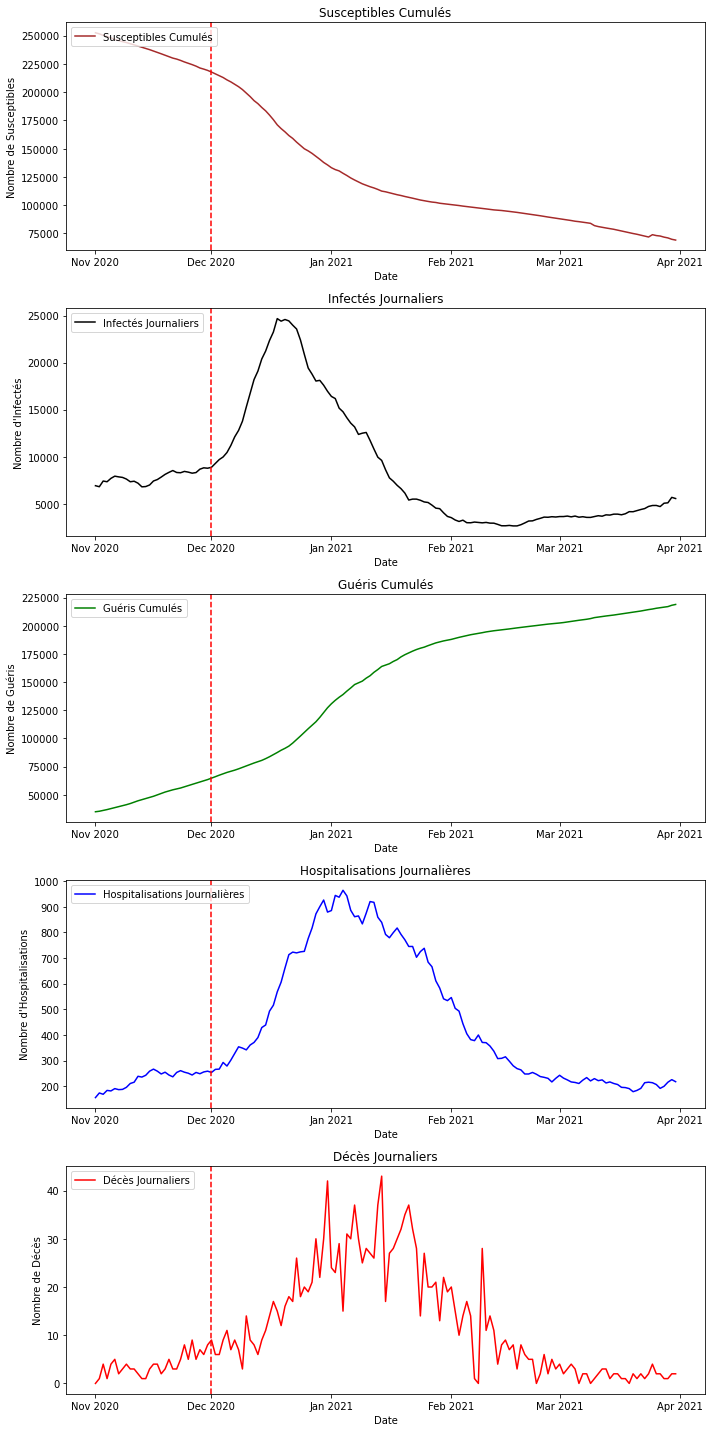

In [572]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

# Définir les dates de début et de fin
start_date = '2020-11-01'
end_date = '2021-03-31'

# Créer une plage de dates
date_range = pd.date_range(start=start_date, end=end_date)

# Créer une figure et des axes pour les sous-plots
fig, axs = plt.subplots(5, figsize=(10, 20))

# Texte indiquant le confinement
confinement_text = 'Début du confinement'

# Plot 1 : Susceptibles cumulés
axs[0].plot(date_range, susceptible, color='brown')
axs[0].set_title('Susceptibles Cumulés')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Nombre de Susceptibles')
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axs[0].legend(['Susceptibles Cumulés', confinement_text], loc='upper left')
axs[0].axvline(datetime.datetime(2020, 12, 1), color='red', linestyle='--')

# Plot 2 : Infectés
axs[1].plot(date_range, cases, color='black')
axs[1].set_title('Infectés Journaliers')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Nombre d\'Infectés')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axs[1].legend(['Infectés Journaliers', confinement_text], loc='upper left')
axs[1].axvline(datetime.datetime(2020, 12, 1), color='red', linestyle='--')

# Plot 3 : Guéris cumulés
axs[2].plot(date_range, recovered, color='green')
axs[2].set_title('Guéris Cumulés')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Nombre de Guéris')
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axs[2].legend(['Guéris Cumulés', confinement_text], loc='upper left')
axs[2].axvline(datetime.datetime(2020, 12, 1), color='red', linestyle='--')

# Plot 4 : Hospitalisations journalières
axs[3].plot(date_range, hosp, color='blue')
axs[3].set_title('Hospitalisations Journalières')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Nombre d\'Hospitalisations')
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axs[3].legend(['Hospitalisations Journalières', confinement_text], loc='upper left')
axs[3].axvline(datetime.datetime(2020, 12, 1), color='red', linestyle='--')

# Plot 5 : Décès journaliers
axs[4].plot(date_range, deaths_daily, color='red')
axs[4].set_title('Décès Journaliers')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Nombre de Décès')
axs[4].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axs[4].legend(['Décès Journaliers', confinement_text], loc='upper left')
axs[4].axvline(datetime.datetime(2020, 12, 1), color='red', linestyle='--')

# Ajuster l'espacement entre les sous-plots
plt.tight_layout()

# Afficher le graphique
plt.show()



## La ligne rouge dans les plots indiquent le confinement qui a eu lieu au début décembre

## Les EDO du modèle SIHRD

# Équations du Modèle SIR Étendu

Les équations suivantes décrivent l'évolution des compartiments dans un modèle épidémiologique SIR étendu, prenant en compte les hospitalisations et les décès.

$$
\frac{dS}{dt} = -\beta \frac{S I}{N}
$$

$$
\frac{dI}{dt} = \beta \frac{S I}{N} - \gamma I - h I
$$

$$
\frac{dH}{dt} = h I - \rho H - d H
$$

$$
\frac{dR}{dt} = \gamma I + \rho H
$$

$$
\frac{dF}{dt} = d H
$$


In [573]:

from numba import njit



from numba import njit
@njit
def rhs(X, t, theta):
    
    S, I, R, H, F= X
    
    beta, gamma,h,rho,d, St0, It0, Rt0,Ht0, Ft0 = theta
     # Les équations
    dS_dt = -beta*S*I/N
    dI_dt = beta*S*I/N-gamma*I-h*I
    dH_dt = -rho*H-d*H+h*I
    dR_dt = gamma*I+rho*H
    
    dF_dt = +d*H
    return [dS_dt, dI_dt, dR_dt, dH_dt,dF_dt]

## Création d'un DataFrame regroupant les données compartimentales

In [574]:
sir_data_observed = pd.DataFrame(
    {'S': susceptible,
     'I': cases,
     'R' : recovered,
     'H': hosp,
    'F' : deaths,
    'F_daily' : deaths_daily})
sir_data_observed

,S,I,R,H,F,F_daily
0,252545,6922,34959,156,723,0
1,251585,6813,35411,174,724,1
2,250237,7418,36111,169,728,4
3,249286,7342,36892,184,729,1
4,248065,7702,37756,182,733,4
...,...,...,...,...,...,...
146,72759,4705,216126,192,2413,2
147,71787,5060,216590,200,2414,1
148,71092,5103,217071,216,2415,1
149,69872,5682,218246,226,2417,2


In [575]:
import pandas as pd

# Assurez-vous que la DataFrame `sir_data_observed` est déjà créée comme suit:
sir_data_observed = pd.DataFrame(
    {'S': susceptible,
     'I': cases,
     'R': recovered,
     'H': hosp,
     'F': deaths,
     'F_daily': deaths_daily})




## Simulation du modèle SIHRD

In [576]:
theta = np.array([0.1, 0.01,0.05,0.05,0.1,N-1000,1000,0,0,0])
day_num = [i for i in range(len(sir_data_observed))]
time = day_num
# Résolution de l'ODE par odeint
x_y = odeint(func=rhs, y0=theta[-5:], t=time, args=(theta,))
S = x_y[:, 0]
I = x_y[:, 1]
R = x_y[:, 2]
H = x_y[:, 3]
F = x_y[:, 4]
F_daily = np.diff(F)

F_daily= np.insert(F_daily,0,0)


In [578]:
sir_data_simulated = pd.DataFrame({
    'S': S.astype(int),
    'I': I.astype(int),
    'R': R.astype(int),
    'H': H.astype(int),
    'F': F.astype(int),
    'F_daily': F_daily.astype(int)
})
sir_data_simulated

,S,I,R,H,F,F_daily
0,299000,1000,0,0,0,0
1,298898,1040,11,47,2,2
2,298792,1082,25,90,9,6
3,298682,1126,42,128,20,10
4,298568,1171,60,164,34,14
...,...,...,...,...,...,...
146,145799,24922,54526,8791,65960,882
147,144600,24635,55211,8717,66835,875
148,143424,24341,55890,8639,67703,867
149,142272,24041,56562,8559,68563,859


In [579]:
sir_data_observed

,S,I,R,H,F,F_daily
0,252545,6922,34959,156,723,0
1,251585,6813,35411,174,724,1
2,250237,7418,36111,169,728,4
3,249286,7342,36892,184,729,1
4,248065,7702,37756,182,733,4
...,...,...,...,...,...,...
146,72759,4705,216126,192,2413,2
147,71787,5060,216590,200,2414,1
148,71092,5103,217071,216,2415,1
149,69872,5682,218246,226,2417,2


## Visualisation des données de simulation

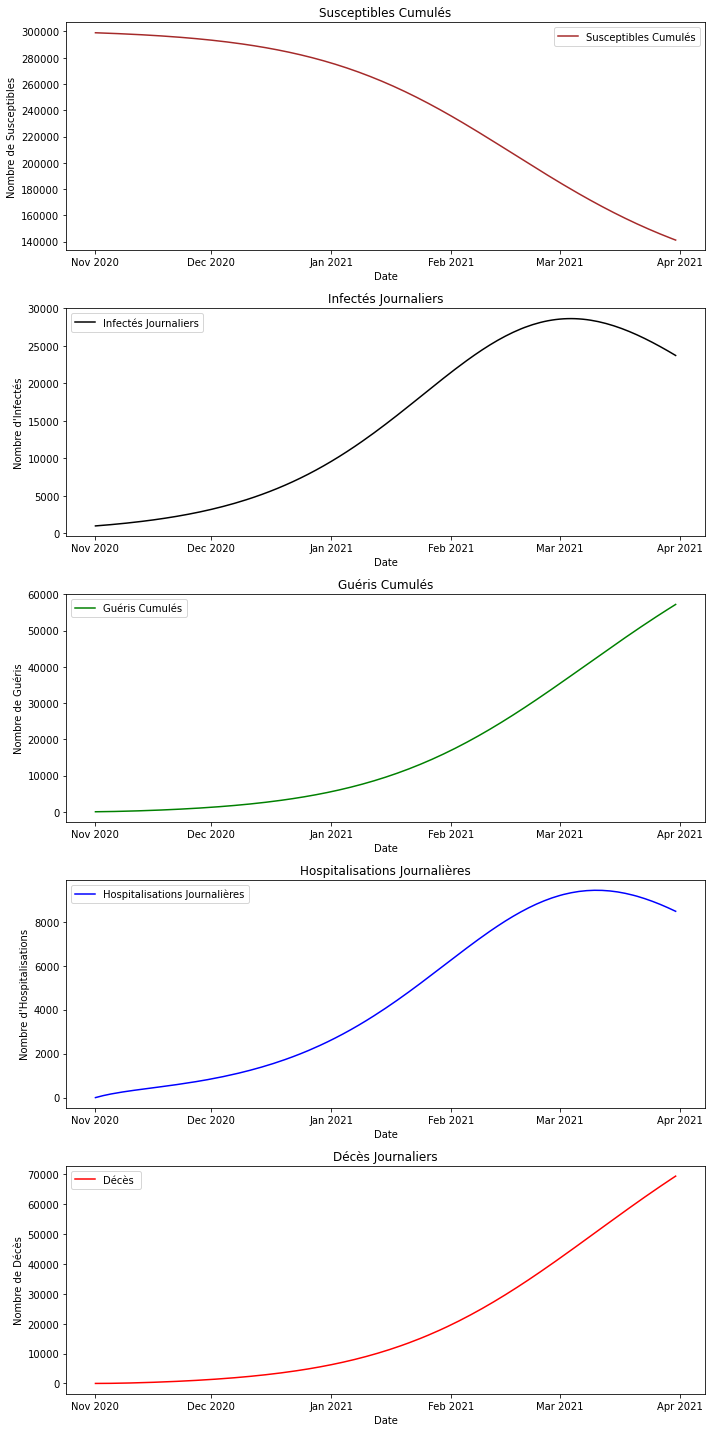

In [580]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

# Définir les dates de début et de fin
start_date = '2020-11-01'
end_date = '2021-03-31'

# Créer une plage de dates
date_range = pd.date_range(start=start_date, end=end_date)

# Créer une figure et des axes pour les sous-plots
fig, axs = plt.subplots(5, figsize=(10, 20))

# Plot 1 : Susceptibles cumulés
axs[0].plot(date_range, sir_data_simulated['S'], color='brown')
axs[0].set_title('Susceptibles Cumulés')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Nombre de Susceptibles')
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axs[0].legend(['Susceptibles Cumulés'])

# Plot 2 : Infectés
axs[1].plot(date_range, sir_data_simulated['I'], color='black')
axs[1].set_title('Infectés Journaliers')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Nombre d\'Infectés')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axs[1].legend(['Infectés Journaliers'])

# Plot 3 : Guéris cumulés
axs[2].plot(date_range, sir_data_simulated['R'], color='green')
axs[2].set_title('Guéris Cumulés')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Nombre de Guéris')
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axs[2].legend(['Guéris Cumulés'])

# Plot 4 : Hospitalisations journalières
axs[3].plot(date_range, sir_data_simulated['H'], color='blue')
axs[3].set_title('Hospitalisations Journalières')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Nombre d\'Hospitalisations')
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axs[3].legend(['Hospitalisations Journalières'])

# Plot 5 : Décès journaliers
axs[4].plot(date_range, sir_data_simulated['F'], color='red')
axs[4].set_title('Décès Journaliers')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Nombre de Décès')
axs[4].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axs[4].legend(['Décès '])

# Ajuster l'espacement entre les sous-plots
plt.tight_layout()

# Afficher le graphique
plt.show()


# Estimation des paramètres du modèle SIHRD sur les données de simulations avec MCMC

Pour convertir une fonction Python en un opérateur Pytensor en utilisant le décorateur @as_op :

1. Nous utilisons le décorateur @as_op pour indiquer à PyMC les types de variables d'entrée et de sortie de la fonction.
2. La fonction odeint renvoie des tableaux Numpy, mais nous indiquons à PyMC qu'ils sont des tenseurs Pytensor de type double flottant à des fins de traitement.

In [581]:
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=rhs, y0=theta[-5:], t=time, args=(theta,))


### Modèle PyMC

In [582]:
theta1 = np.array([0.3, 0.1, 0.1, 0.2, 0.015,N-1000,1000,0.1,0.1,0.1]) # prior loin de la solution pour tester le MCMC

with pm.Model() as model:
    # Les Priors
    ## les paramètres
    beta = pm.TruncatedNormal("beta", mu=theta1[0], sigma=1, lower=0, initval=theta1[0])
    gamma = pm.TruncatedNormal("gamma", mu=theta1[1], sigma=1, lower=0, initval=theta1[1])
    h = pm.TruncatedNormal("h", mu=theta1[2], sigma=1, lower=0, initval=theta1[2])
    rho = pm.TruncatedNormal("rho", mu=theta1[3], sigma=1, lower=0, initval=theta1[3])
    d = pm.TruncatedNormal("d", mu=abs(theta1[4]), sigma=1, lower=0, initval=abs(theta1[4]))
   
    ## les conditions initiales
    S0 = pm.TruncatedNormal("S0", mu=abs(theta1[5]), sigma=1, lower=0, initval=abs(theta1[5]))
    I0 = pm.TruncatedNormal("I0", mu=theta1[6], sigma=1, lower=0, initval=theta1[6])
    R0 = pm.TruncatedNormal("R0", mu=theta1[7], sigma=1, lower=0, initval=theta1[7])
    H0 = pm.TruncatedNormal("H0", mu=theta1[8], sigma=1, lower=0, initval=theta1[8])
    F0 = pm.TruncatedNormal("F0", mu=theta1[9], sigma=1, lower=0, initval=theta1[9])
    sigma = pm.HalfNormal("sigma", 10)

    # Solution de l'ODE
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([beta,  gamma, h, rho, d, S0, I0, R0, H0, F0]))

    b = ode_solution
    # Le Likelihood qui prend en compte pour le moment de tous les compartiments 
    # car les données proviennet d'une simulation
    # Avec des données observées on va utiliser que les données de déces et d'hospitalisations 
    #car elles sont les plus fiables(I et R sont souvent biaisées) 
    pm.Poisson("Y_obs", mu=b, observed=sir_data_simulated[["S","I","R","H","F"]])


    

In [583]:
# Variable list to give to the sample step parameter
vars_list = list(model.values_to_rvs.keys())[:-1]
vars_list

[beta_interval__,
 gamma_interval__,
 h_interval__,
 rho_interval__,
 d_interval__,
 S0_interval__,
 I0_interval__,
 R0_interval__,
 H0_interval__,
 F0_interval__,
 sigma_log__]

In [589]:
sampler = "DEMetropolisZ"
tune = draws = 10000
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws)
trace = trace_DEMZ
az.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [beta, gamma, h, rho, d, S0, I0, R0, H0, F0, sigma]


/home/ider/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ider/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ider/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ider/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 36 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliab

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.105,0.008,0.100,0.118,0.004,0.003,7.0,37.0,1.63
gamma,0.012,0.010,0.004,0.028,0.005,0.004,5.0,27.0,2.57
h,0.051,0.006,0.042,0.056,0.003,0.002,5.0,11.0,3.03
rho,0.058,0.011,0.043,0.071,0.005,0.004,5.0,27.0,2.20
d,0.119,0.036,0.099,0.182,0.018,0.014,5.0,11.0,2.61
S0,299000.375,3.578,298997.716,299002.372,0.384,0.272,193.0,135.0,1.02
I0,862.552,232.903,458.397,1000.725,116.382,89.165,6.0,32.0,1.82
R0,0.331,0.373,0.009,0.999,0.186,0.142,5.0,12.0,3.07
H0,0.496,0.454,0.002,1.229,0.226,0.174,5.0,12.0,2.90
F0,0.174,0.163,0.023,0.478,0.080,0.061,5.0,27.0,2.94


# Analyse du Posterior

Les fonctionnalités de traçage et de diagnostic de PyMC sont maintenant prises en charge par un package dédié et indépendant de la plateforme nommé Arviz. Un simple graphique postérieur peut être créé en utilisant `plot_trace`.

## Exemple de Traçage du Posterior avec Arviz

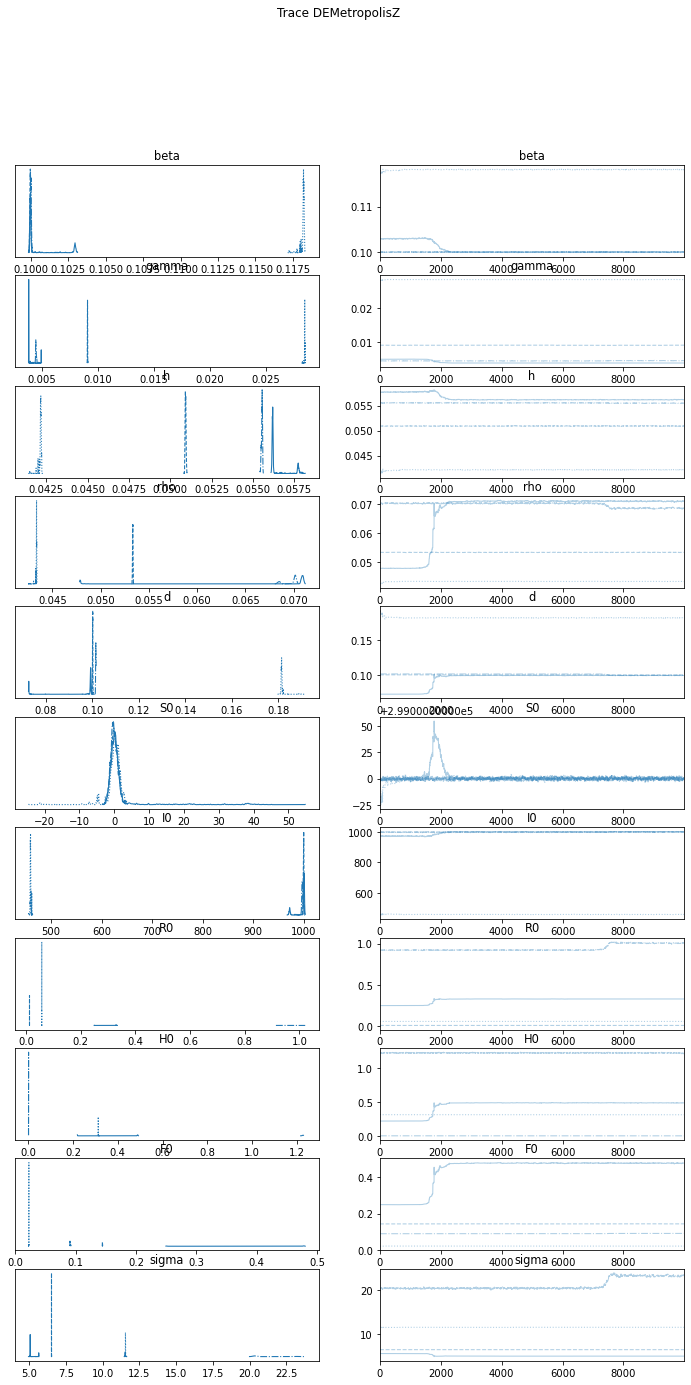

In [590]:
az.plot_trace(trace)
plt.suptitle(f"Trace {sampler}");

De plus, la fonction `summary` fournit une sortie textuelle des statistiques du posterior :


In [591]:
df = az.summary(trace)
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.105,0.008,0.100,0.118,0.004,0.003,7.0,37.0,1.63
gamma,0.012,0.010,0.004,0.028,0.005,0.004,5.0,27.0,2.57
h,0.051,0.006,0.042,0.056,0.003,0.002,5.0,11.0,3.03
rho,0.058,0.011,0.043,0.071,0.005,0.004,5.0,27.0,2.20
d,0.119,0.036,0.099,0.182,0.018,0.014,5.0,11.0,2.61
S0,299000.375,3.578,298997.716,299002.372,0.384,0.272,193.0,135.0,1.02
I0,862.552,232.903,458.397,1000.725,116.382,89.165,6.0,32.0,1.82
R0,0.331,0.373,0.009,0.999,0.186,0.142,5.0,12.0,3.07
H0,0.496,0.454,0.002,1.229,0.226,0.174,5.0,12.0,2.90
F0,0.174,0.163,0.023,0.478,0.080,0.061,5.0,27.0,2.94


### Extraction des meilleurs paramètres trouvés par MCMC

In [592]:
theta_predicted = df['mean'].tolist()
theta_predicted = theta_predicted[0:-1]


In [593]:
# Impression des valeurs
print("Comparaison des paramètres simulés et prédits")
print("--------------------------------------------")
print("{:<10} | {:<15} | {:<15}".format("Paramètre", "Simulé", "Prédit"))
print("--------------------------------------------")
for i in range(len(theta)):
    print("{:<10} | {:<15} | {:<15}".format(f"theta[{i}]", theta[i], theta_predicted[i]))
print("--------------------------------------------")

Comparaison des paramètres simulés et prédits
--------------------------------------------
Paramètre  | Simulé          | Prédit         
--------------------------------------------
theta[0]   | 0.1             | 0.105          
theta[1]   | 0.01            | 0.012          
theta[2]   | 0.05            | 0.051          
theta[3]   | 0.05            | 0.058          
theta[4]   | 0.1             | 0.119          
theta[5]   | 299000.0        | 299000.375     
theta[6]   | 1000.0          | 862.552        
theta[7]   | 0.0             | 0.331          
theta[8]   | 0.0             | 0.496          
theta[9]   | 0.0             | 0.174          
--------------------------------------------


Les paramètres estimés par la méthode MCMC correspondent bien au jeu de paramètres $\theta = \begin{bmatrix} \beta & \gamma & h & \rho & d & St_0 & It_0 & Rt_0 & Ht_0 & Ft_0 \end{bmatrix}$ avec les valeurs suivantes :

- $\beta$: 0.1
- $\gamma$: 0.01
- $h$: 0.05
- $\rho$: 0.05
- $d$: 0.1
- $St_0$: 299 000
- $It_0$: 1000
- $Rt_0$: 0
- $Ht_0$: 0
- $Ft_0$: 0

Ces paramètres correspondent au jeu avec lequel le modèle a été simulé. Cette convergence réussie indique que le MCMC fonctionne efficacement pour estimer les paramètres du modèle, ouvrant ainsi la voie à son application sur des données réelles observées.


# Calibration du modèle SIHRD sur les données observées

## Estimation de paramètres du modèle avec le MCMC 

Pour convertir une fonction Python en un opérateur Pytensor en utilisant le décorateur @as_op :

1. Nous utilisons le décorateur @as_op pour indiquer à PyMC les types de variables d'entrée et de sortie de la fonction.
2. La fonction odeint renvoie des tableaux Numpy, mais nous indiquons à PyMC qu'ils sont des tenseurs Pytensor de type double flottant à des fins de traitement.


In [594]:
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=rhs, y0=theta[-5:], t=time, args=(theta,))


### Modèle PyMC

Maintenant, nous pouvons spécifier le modèle PyMC en utilisant le solveur ode ! Pour les priors, nous utiliserons les résultats du calcul des moindres carrés (`results.x`) pour attribuer des priors qui commencent dans la bonne plage. Ceux-ci sont des priors faiblement informatifs dérivés empiriquement. Nous les rendons également positifs uniquement pour ce problème.

Nous utiliserons une vraisemblance de Poisson sur les données non transformées (c'est-à-dire non transformées logarithmiquement) pour mieux ajuster les pics des données.


In [595]:
theta1 = np.array([0.3, 0.1,0.1,0.2,0.015,sir_data_observed['S'][0],sir_data_observed['I'][0],sir_data_observed['R'][0],sir_data_observed['H'][0],sir_data_observed['F'][0]]) # Utiliser l'estimation fournie par la méthode des moindres carrées pour définir les priors

theta1 = [abs(i) for i in theta1] # Rendre les paramètres priors estimées par les Moindres carrées positives
with pm.Model() as model:

    # Les Priors
    ## les paramètres
    beta = pm.TruncatedNormal("beta", mu=theta1[0], sigma=1, lower=0, initval=theta1[0])
    gamma = pm.TruncatedNormal("gamma", mu=theta1[1], sigma=1, lower=0, initval=theta1[1])
    h = pm.TruncatedNormal("h", mu=theta1[2], sigma=1, lower=0, initval=theta1[2])
    rho = pm.TruncatedNormal("rho", mu=theta1[3], sigma=1, lower=0, initval=theta1[3])
    d = pm.TruncatedNormal("d", mu=abs(theta1[4]), sigma=1, lower=0, initval=abs(theta1[4]))
   
    ## les conditions initiales
    S0 = pm.TruncatedNormal("S0", mu=abs(theta1[5]), sigma=50, lower=0, initval=abs(theta1[5]))
    I0 = pm.TruncatedNormal("I0", mu=theta1[6], sigma=50, lower=0, initval=theta1[6])
    R0 = pm.TruncatedNormal("R0", mu=theta1[7], sigma=50, lower=0, initval=theta1[7])
    H0 = pm.TruncatedNormal("H0", mu=theta1[8], sigma=50, lower=0, initval=theta1[8])
    F0 = pm.TruncatedNormal("F0", mu=theta1[9], sigma=50, lower=0, initval=theta1[9])
    sigma = pm.HalfNormal("sigma", 10)

    # Solution de l'ODE
   
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([beta,  gamma, h,rho,d,S0, I0,R0,H0,F0]))

    b = ode_solution[:,[3,4]]
    # Le Likelihood qui prend en compte seulement les incidences hospitalières et de dècés F_daily
    pm.Poisson("Y_obs", mu=b ,observed=sir_data_observed[["H","F"]])
    

    

In [596]:
# Variable list to give to the sample step parameter
vars_list = list(model.values_to_rvs.keys())[:-1]
vars_list

[beta_interval__,
 gamma_interval__,
 h_interval__,
 rho_interval__,
 d_interval__,
 S0_interval__,
 I0_interval__,
 R0_interval__,
 H0_interval__,
 F0_interval__,
 sigma_log__]

In [598]:
sampler = "DEMetropolisZ"
tune = draws = 5000
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws)
trace = trace_DEMZ
az.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [beta, gamma, h, rho, d, S0, I0, R0, H0, F0, sigma]


/home/ider/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ider/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ider/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ider/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.199,0.037,0.125,0.238,0.018,0.014,5.0,11.0,3.09
gamma,0.087,0.018,0.058,0.128,0.008,0.006,5.0,11.0,2.10
h,0.042,0.024,0.004,0.064,0.012,0.009,5.0,11.0,2.65
rho,0.449,0.238,0.167,0.740,0.116,0.089,4.0,14.0,3.21
d,0.030,0.004,0.026,0.035,0.002,0.001,5.0,21.0,2.13
S0,252494.270,227.445,252274.872,253011.654,32.198,22.905,54.0,30.0,1.26
I0,2669.934,1499.559,1418.499,5801.657,713.101,541.831,5.0,11.0,2.84
R0,34892.711,275.712,34513.810,35533.819,99.346,73.261,7.0,13.0,1.58
H0,215.531,93.207,110.763,357.143,44.997,34.273,5.0,19.0,2.81
F0,609.655,142.246,439.235,746.550,60.658,45.398,5.0,23.0,2.12


# Analyse du Posterior

Les fonctionnalités de traçage et de diagnostic de PyMC sont maintenant prises en charge par un package dédié et indépendant de la plateforme nommé Arviz. Un simple graphique postérieur peut être créé en utilisant `plot_trace`.

## Exemple de Traçage du Posterior avec Arviz


<span style="color:black">




- estimation de paramètres du modèle avec le MCMC en se basant sur les priors
</span>



La colonne de gauche consiste en un histogramme lissé (utilisant une estimation de densité par noyau) des postérieurs marginaux de chaque variable aléatoire stochastique, tandis que la colonne de droite contient les échantillons de la chaîne de Markov tracés dans l'ordre séquentiel.


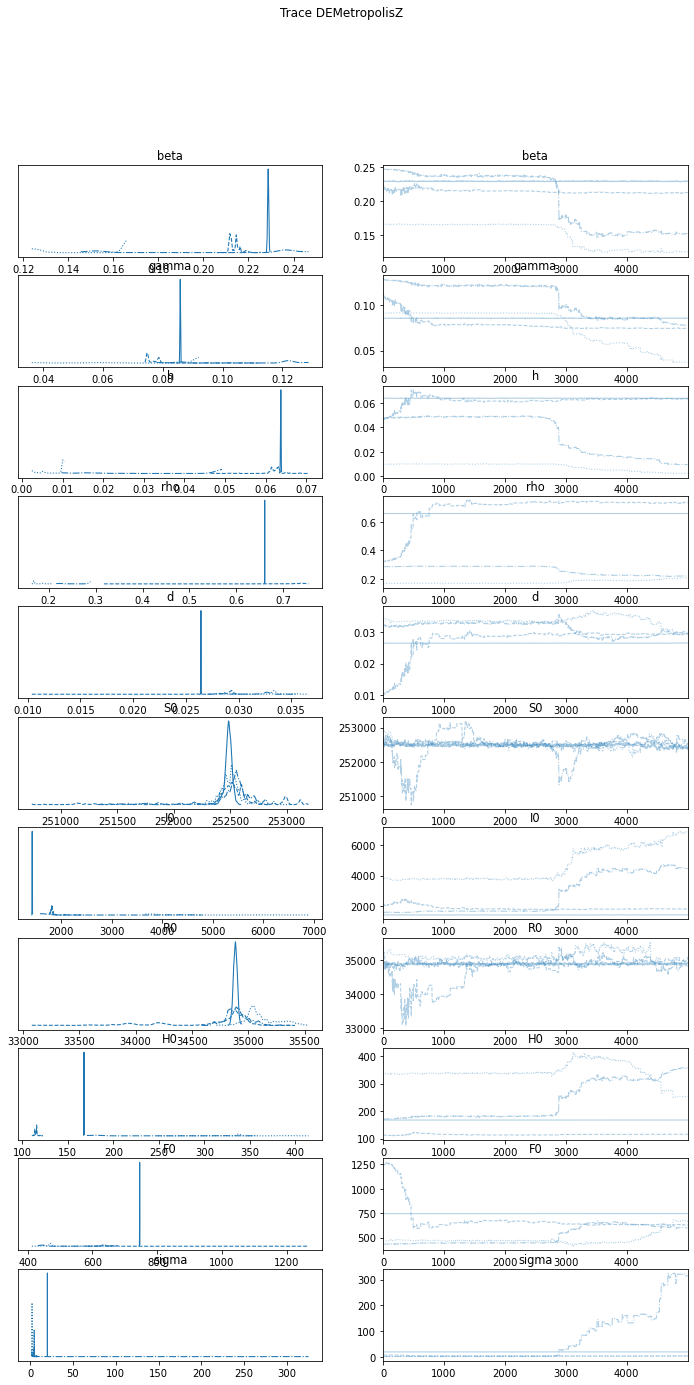

In [599]:
az.plot_trace(trace)
plt.suptitle(f"Trace {sampler}");

De plus, la fonction `summary` fournit une sortie textuelle des statistiques du posterior :


In [600]:
df = az.summary(trace)
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.199,0.037,0.125,0.238,0.018,0.014,5.0,11.0,3.09
gamma,0.087,0.018,0.058,0.128,0.008,0.006,5.0,11.0,2.10
h,0.042,0.024,0.004,0.064,0.012,0.009,5.0,11.0,2.65
rho,0.449,0.238,0.167,0.740,0.116,0.089,4.0,14.0,3.21
d,0.030,0.004,0.026,0.035,0.002,0.001,5.0,21.0,2.13
S0,252494.270,227.445,252274.872,253011.654,32.198,22.905,54.0,30.0,1.26
I0,2669.934,1499.559,1418.499,5801.657,713.101,541.831,5.0,11.0,2.84
R0,34892.711,275.712,34513.810,35533.819,99.346,73.261,7.0,13.0,1.58
H0,215.531,93.207,110.763,357.143,44.997,34.273,5.0,19.0,2.81
F0,609.655,142.246,439.235,746.550,60.658,45.398,5.0,23.0,2.12


### Extraction des meilleurs paramètres trouvés par MCMC

In [601]:
theta = df['mean'].tolist()
theta=theta[0:-1]

### Comparaison des données prédites vs données observées

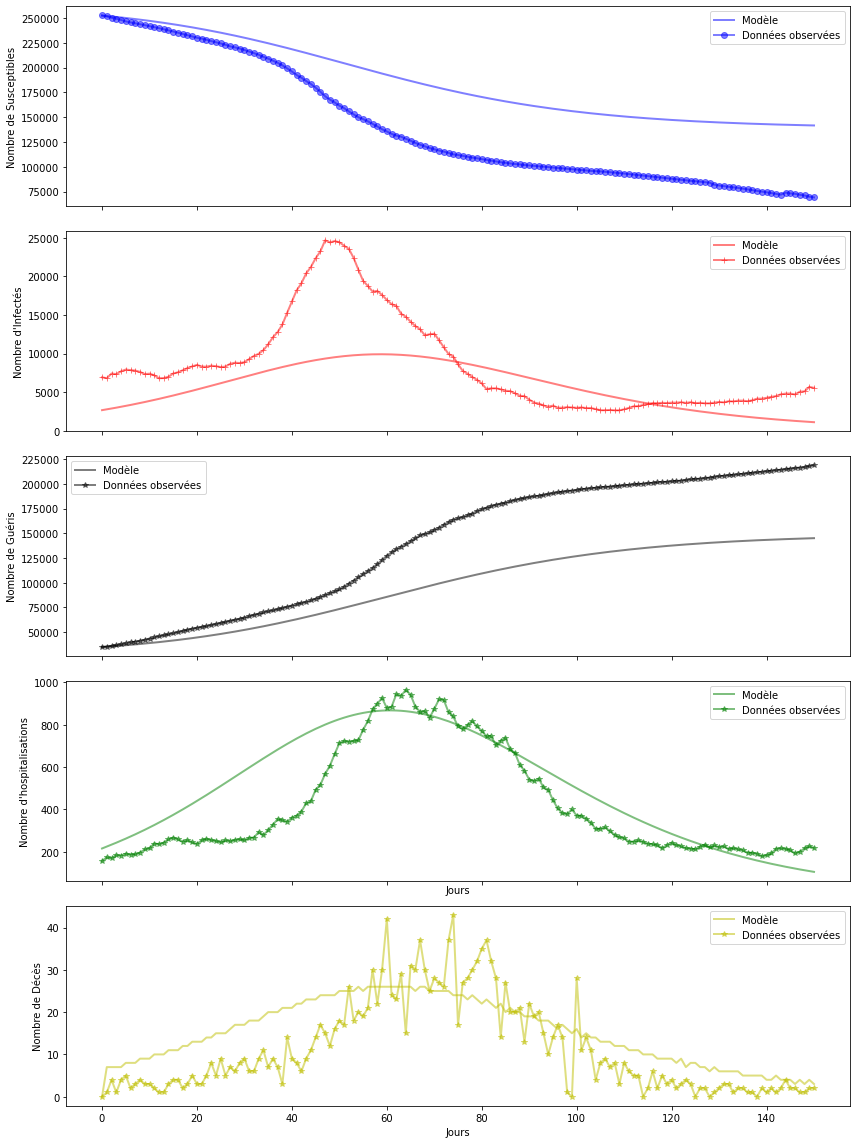

In [603]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np

# Supposons que rhs, results, day_num et sir_data_observed soient déjà définis

# Variables de temps et paramètres
time = day_num


# Résolution des équations différentielles
x_y = odeint(func=rhs, y0=theta[-5:], t=day_num, args=(theta,))
# Extract the cumulative deaths column
cumulative_deaths = x_y[:, -1].astype(int)
# Calculate daily deaths
daily_deaths = np.diff(cumulative_deaths)
daily_deaths = np.insert(daily_deaths, 0, 0)
x_y = np.column_stack([x_y[:, :-1], daily_deaths])


fig, axs = plt.subplots(5, figsize=(12, 16), sharex=True)

# Susceptibles
axs[0].plot(time, x_y[:,0], 'b', alpha=0.5, lw=2, label='Modèle')
axs[0].plot(time, sir_data_observed.S, 'b', alpha=0.5, lw=2, marker="o", label='Données observées')
axs[0].set_ylabel('Nombre de Susceptibles')
axs[0].legend()

# Infectés
axs[1].plot(time, x_y[:,1], 'r', alpha=0.5, lw=2, label='Modèle')
axs[1].plot(time, sir_data_observed.I, 'r', alpha=0.5, lw=2, marker="+", label='Données observées')
axs[1].set_ylabel('Nombre d\'Infectés')
axs[1].legend()

# Guéris
axs[2].plot(time, x_y[:,2], 'black', alpha=0.5, lw=2, label='Modèle')
axs[2].plot(time, sir_data_observed.R, 'black', alpha=0.5, lw=2, marker="*", label='Données observées')
axs[2].set_ylabel('Nombre de Guéris')
axs[2].legend()

# Décès
axs[4].plot(time, x_y[:,4], 'y', alpha=0.5, lw=2, label='Modèle')
axs[4].plot(time, sir_data_observed.F_daily, 'y', alpha=0.5, lw=2, marker="*", label='Données observées')
axs[4].set_ylabel('Nombre de Décès')
axs[4].set_xlabel('Jours')
axs[4].legend()
# Hospitalisations
axs[3].plot(time, x_y[:,3], 'g', alpha=0.5, lw=2, label='Modèle')
axs[3].plot(time, sir_data_observed.H, 'g', alpha=0.5, lw=2, marker="*", label='Données observées')
axs[3].set_ylabel("Nombre d'hospitalisations")
axs[3].set_xlabel('Jours')
axs[3].legend()

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage du graphique
plt.show()



## Analyse de sensibilité par Perturbation des Paramètres

[0.1, 0.01, 0.05, 0.05, 0.1, 299000.0, 1000.0, 0.0, 0.0, 0.0]

# Modèle SIRHD par classes d'ages

Etant donnée que les données par classes d'ages du Danemark sont introuvables, je me suis basée sur certains articles, pour faire des hypothèses sur le pourcentage de personnes qui entrent dans les compartiments S I R H D.
https://pubmed.ncbi.nlm.nih.gov/32887982/#:~:text=Conclusions%3A%20In%20this%20nationwide%20population,the%20age%20of%2080%20years.


## 3 classes d'ages: Les enfants(0-18), les adultes(18-65) et les personnes agées(65+)

## Application des pourcentages sur les données observées initiales et création d'une DataFrame qui regroupe les données par classes d'ages

#### Ici on doit faire attention au fait que la population varie en fonction de la classes d'ages: On a au total 3 populations
- N1: La population des enfants(0-18) 
- N2: La population des adultes(18-65)
- N3: La population des personnes agées(+65)


## EDOs du modèle SIRHD par classe d'ages 

\begin{align*}
\frac{dS_1}{dt} &= -\text{coef} \cdot (\beta_{11} I_1 + \beta_{12} I_2 + \beta_{13} I_3) \cdot \frac{S_1}{N_1} \\
\frac{dI_1}{dt} &= \text{coef} \cdot (\beta_{11} I_1 + \beta_{12} I_2 + \beta_{13} I_3) \cdot \frac{S_1}{N_1} - \gamma I_1 - \alpha_1 I_1 - h I_1 \\
\frac{dH_1}{dt} &= h I_1 - \rho H_1 - d H_1 \\
\frac{dR_1}{dt} &= \gamma I_1 + \rho H_1 \\
\frac{dF_1}{dt} &= \alpha_1 I_1 + d H_1 \\
\\
\frac{dS_2}{dt} &= -\text{coef} \cdot (\beta_{21} I_1 + \beta_{22} I_2 + \beta_{23} I_3) \cdot \frac{S_2}{N_2} \\
\frac{dI_2}{dt} &= \text{coef} \cdot (\beta_{21} I_1 + \beta_{22} I_2 + \beta_{23} I_3) \cdot \frac{S_2}{N_2} - \gamma I_2 - \alpha_2 I_2 - h I_2 \\
\frac{dH_2}{dt} &= h I_2 - \rho H_2 - d H_2 \\
\frac{dR_2}{dt} &= \gamma I_2 + \rho H_2 \\
\frac{dF_2}{dt} &= \alpha_2 I_2 + d H_2 \\
\\
\frac{dS_3}{dt} &= -\text{coef} \cdot (\beta_{31} I_1 + \beta_{32} I_2 + \beta_{33} I_3) \cdot \frac{S_3}{N_3} \\
\frac{dI_3}{dt} &= \text{coef} \cdot (\beta_{31} I_1 + \beta_{32} I_2 + \beta_{33} I_3) \cdot \frac{S_3}{N_3} - \gamma I_3 - \alpha_3 I_3 - h I_3 \\
\frac{dH_3}{dt} &= h I_3 - \rho H_3 - d H_3 \\
\frac{dR_3}{dt} &= \gamma I_3 + \rho H_3 \\
\frac{dF_3}{dt} &= \alpha_3 I_3 + d H_3 \\
\end{align*}



## Les EDOs du modèle SIRHD par classes d'ages

In [554]:
from numba import njit
import numpy as np

@njit
def rhs_prime(X, t, theta):
    S1, I1, R1, H1, F1, S2, I2, R2, H2, F2, S3, I3, R3, H3, F3 = X
# Populations des 3 classes d'âges
    N1 = 96381
    N2 = 373702
    N3 = 116857
    coef, gamma, alpha1, alpha2, alpha3, h, rho, d = theta
    beta_matrix = np.array([[2.28, 2.78, 0.20], [0.71, 2.81, 0.41], [0.16, 1.29, 1.05]])
    
    dS_dt1 = -coef * (beta_matrix[0][0] * I1 + beta_matrix[0][1] * I2 + beta_matrix[0][2] * I3) * S1 / N1
    dI_dt1 = coef * (beta_matrix[0][0] * I1 + beta_matrix[0][1] * I2 + beta_matrix[0][2] * I3) * S1 / N1 - gamma * I1 - alpha1 * I1 - h * I1
    dH_dt1 = h * I1 - rho * H1 - d * H1
    dR_dt1 = gamma * I1 + rho * H1
    dF_dt1 = alpha1 * I1 + d * H1

    dS_dt2 = -coef * (beta_matrix[1][0] * I1 + beta_matrix[1][1] * I2 + beta_matrix[1][2] * I3) * S2 / N2
    dI_dt2 = coef * (beta_matrix[1][0] * I1 + beta_matrix[1][1] * I2 + beta_matrix[1][2] * I3) * S2 / N2 - gamma * I2 - alpha2 * I2 - h * I2
    dH_dt2 = h * I2 - rho * H2 - d * H2
    dR_dt2 = gamma * I2 + rho * H2
    dF_dt2 = alpha2 * I2 + d * H2

    dS_dt3 = -coef * (beta_matrix[2][0] * I1 + beta_matrix[2][1] * I2 + beta_matrix[2][2] * I3) * S3 / N3
    dI_dt3 = coef * (beta_matrix[2][0] * I1 + beta_matrix[2][1] * I2 + beta_matrix[2][2] * I3) * S3 / N3 - gamma * I3 - alpha3 * I3 - h * I3
    dH_dt3 = h * I3 - rho * H3 - d * H3
    dR_dt3 = gamma * I3 + rho * H3
    dF_dt3 = alpha3 * I3 + d * H3

    return [dS_dt1, dI_dt1, dR_dt1, dH_dt1, dF_dt1, dS_dt2, dI_dt2, dR_dt2, dH_dt2, dF_dt2, dS_dt3, dI_dt3, dR_dt3, dH_dt3, dF_dt3]


## Calibration du modèle SIRHD par classes d'ages sur les données observées(trouvées par appilcation de pourcentages sur les données observées initiales)

## Extraction des données de classes d'ages par appilcation de pourcentages sur les données observées(indisponibilité des données classées par ages )

In [515]:
import pandas as pd

# Création initiale du DataFrame avec des colonnes vides
sir_data = pd.DataFrame(columns=['S1', 'I1', 'R1', 'H1', 'F1', 'S2', 'I2', 'R2', 'H2', 'F2', 'S3', 'I3', 'R3', 'H3', 'F3'])

# Populations des 3 classes d'âges
N1 = 96381
N2 = 373702
N3 = 116857

# Supposons que `sir_data_observed` et les pourcentages sont déjà définis
# sir_data_observed = pd.DataFrame(...) # Exemple d'initialisation

# Supposons que les pourcentages d'hospitalisation pour chaque classe d'âge sont donnés
hosp_percentage = [0.2, 0.2, 0.6]  # Exemple de pourcentages d'hospitalisation pour chaque classe d'âge
cases_percentage = [0.25, 0.6, 0.15]
recoveries_percentage = [0.4, 0.4, 0.2]
deaths_percentage = [0.1, 0.3, 0.6]

# Application des pourcentages pour créer les classes d'âges
sir_data['I1'] = sir_data_observed['I'] * cases_percentage[0]
sir_data['R1'] = sir_data_observed['R'] * recoveries_percentage[0]
sir_data['F1'] = sir_data_observed['F'] * deaths_percentage[0]
sir_data['H1'] = sir_data_observed['H'] * hosp_percentage[0]
sir_data['S1'] = N1 - sir_data['I1'] - sir_data['R1'] - sir_data['F1'] - sir_data['H1']

sir_data['I2'] = sir_data_observed['I'] * cases_percentage[1]
sir_data['R2'] = sir_data_observed['R'] * recoveries_percentage[1]
sir_data['F2'] = sir_data_observed['F'] * deaths_percentage[1]
sir_data['H2'] = sir_data_observed['H'] * hosp_percentage[1]
sir_data['S2'] = N2 - sir_data['I2'] - sir_data['R2'] - sir_data['F2'] - sir_data['H2']

sir_data['I3'] = sir_data_observed['I'] * cases_percentage[2]
sir_data['R3'] = sir_data_observed['R'] * recoveries_percentage[2]
sir_data['F3'] = sir_data_observed['F'] * deaths_percentage[2]
sir_data['H3'] = sir_data_observed['H'] * hosp_percentage[2]
sir_data['S3'] = N3 - sir_data['I3'] - sir_data['R3'] - sir_data['F3'] - sir_data['H3']
# Calculate daily deaths for each age group
F1_cumulative = sir_data['F1']
F2_cumulative = sir_data['F2']
F3_cumulative = sir_data['F3']

F1_daily = np.insert(np.diff(F1_cumulative), 0, 0)
F2_daily = np.insert(np.diff(F2_cumulative), 0, 0)
F3_daily = np.insert(np.diff(F3_cumulative), 0, 0)

# Assign daily deaths to new columns in sir_data
sir_data['F1_daily'] = F1_daily
sir_data['F2_daily'] = F2_daily
sir_data['F3_daily'] = F3_daily


# Affichage du DataFrame final
print(sir_data)


           S1       I1       R1    H1     F1        S2      I2       R2    H2  \
0    80563.40  1730.50  13983.6  31.2   72.3  355317.1  4153.2  13983.6  31.2   
1    80406.15  1703.25  14164.4  34.8   72.4  355197.8  4087.8  14164.4  34.8   
2    79975.50  1854.50  14444.4  33.8   72.8  354554.6  4450.8  14444.4  33.8   
3    79679.00  1835.50  14756.8  36.8   72.9  354284.5  4405.2  14756.8  36.8   
4    79243.40  1925.50  15102.4  36.4   73.3  353722.1  4621.2  15102.4  36.4   
..        ...      ...      ...   ...    ...       ...     ...      ...   ...   
146   8474.65  1176.25  86450.4  38.4  241.3  283666.3  2823.0  86450.4  38.4   
147   8198.60  1265.00  86636.0  40.0  241.4  283265.8  3036.0  86636.0  40.0   
148   7992.15  1275.75  86828.4  43.2  241.5  283044.1  3061.8  86828.4  43.2   
149   7375.20  1420.50  87298.4  45.2  241.7  282224.1  3409.2  87298.4  45.2   
150   7111.75  1389.75  87594.0  43.6  241.9  282003.3  3335.4  87594.0  43.6   

        F2         S3      

In [516]:
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=rhs_prime, y0=x_0, t=time, args=(theta,))

In [517]:
import pymc as pm
import numpy as np
import pytensor.tensor as tt

# Supposons que sir_data est déjà défini et contient les données observées
theta1 = [0.03, 0.115, 0.001, 0.001, 0.002, 0.01, 0.02, 0.01]  # Ajout des valeurs initiales pour h, rho et d
theta1 = [0.028, 0.072, 0.001, 0.001, 0.001, 0.002, 0.075, 0.007]
# Définir les conditions initiales
x_0 = np.array([
    sir_data.S1[0], sir_data.I1[0], sir_data.R1[0], sir_data.H1[0], sir_data.F1[0],
    sir_data.S2[0], sir_data.I2[0], sir_data.R2[0], sir_data.H2[0], sir_data.F2[0],
    sir_data.S3[0], sir_data.I3[0], sir_data.R3[0], sir_data.H3[0], sir_data.F3[0]
])

with pm.Model() as model:
    # Les Priors
    coef = pm.TruncatedNormal("coef", mu=theta1[0], sigma=0.1, lower=0, initval=theta1[0])
    gamma = pm.TruncatedNormal("gamma", mu=theta1[1], sigma=0.1, lower=0, initval=theta1[1])
    alpha1 = pm.TruncatedNormal("alpha1", mu=theta1[2], sigma=0.1, lower=0, initval=theta1[2])
    alpha2 = pm.TruncatedNormal("alpha2", mu=theta1[3], sigma=0.1, lower=0, initval=theta1[3])
    alpha3 = pm.TruncatedNormal("alpha3", mu=theta1[4], sigma=0.1, lower=0, initval=theta1[4])
    h = pm.TruncatedNormal("h", mu=theta1[5], sigma=0.1, lower=0, initval=theta1[5])
    rho = pm.TruncatedNormal("rho", mu=theta1[6], sigma=0.1, lower=0, initval=theta1[6])
    d = pm.TruncatedNormal("d", mu=theta1[7], sigma=0.1, lower=0, initval=theta1[7])

    sigma = pm.HalfNormal("sigma", 5)


    # Solution de l'ODE
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([coef, gamma, alpha1, alpha2, alpha3, h, rho, d])
    )

    # Extraction des variables d'intérêt
    b = ode_solution[:, [3, 4, 8, 9, 13, 14]]  # Indices des variables H et F pour les 3 classes d'âge

    # Définir le Likelihood
    pm.Poisson("Y_obs", mu=b, observed=sir_data[["H1", "F1", "H2", "F2", "H3", "F3"]])


In [518]:
# Variable list to give to the sample step parameter
vars_list = list(model.values_to_rvs.keys())[:-1]
vars_list

[coef_interval__,
 gamma_interval__,
 alpha1_interval__,
 alpha2_interval__,
 alpha3_interval__,
 h_interval__,
 rho_interval__,
 d_interval__,
 sigma_log__]

In [519]:
sampler = "DEMetropolisZ"
tune = draws = 1500
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws)
trace = trace_DEMZ
az.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [coef, gamma, alpha1, alpha2, alpha3, h, rho, d, sigma]


/home/ider/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ider/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ider/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/ider/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rh

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coef,0.049,0.009,0.030,0.058,0.004,0.003,5.0,11.0,2.92
gamma,0.131,0.022,0.088,0.159,0.011,0.008,4.0,12.0,3.17
alpha1,0.000,0.000,0.000,0.000,0.000,0.000,5.0,12.0,2.45
alpha2,0.000,0.000,0.000,0.000,0.000,0.000,5.0,17.0,2.87
alpha3,0.002,0.000,0.001,0.003,0.000,0.000,5.0,12.0,3.07
h,0.001,0.001,0.000,0.004,0.001,0.001,4.0,16.0,3.21
rho,0.035,0.043,0.003,0.115,0.021,0.016,4.0,16.0,3.28
d,0.008,0.004,0.004,0.015,0.002,0.001,5.0,11.0,3.06
sigma,5.775,3.610,0.826,13.723,1.778,1.359,4.0,12.0,3.95


In [520]:
df = az.summary(trace)
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coef,0.049,0.009,0.030,0.058,0.004,0.003,5.0,11.0,2.92
gamma,0.131,0.022,0.088,0.159,0.011,0.008,4.0,12.0,3.17
alpha1,0.000,0.000,0.000,0.000,0.000,0.000,5.0,12.0,2.45
alpha2,0.000,0.000,0.000,0.000,0.000,0.000,5.0,17.0,2.87
alpha3,0.002,0.000,0.001,0.003,0.000,0.000,5.0,12.0,3.07
h,0.001,0.001,0.000,0.004,0.001,0.001,4.0,16.0,3.21
rho,0.035,0.043,0.003,0.115,0.021,0.016,4.0,16.0,3.28
d,0.008,0.004,0.004,0.015,0.002,0.001,5.0,11.0,3.06
sigma,5.775,3.610,0.826,13.723,1.778,1.359,4.0,12.0,3.95


In [521]:

theta = df['mean'].tolist()
theta=theta[0:-1]

In [522]:
theta

[0.049, 0.131, 0.0, 0.0, 0.002, 0.001, 0.035, 0.008]

In [523]:
import numpy as np
from scipy.integrate import odeint

# Définition des variables
day_num = np.arange(len(sir_data))
time = day_num
# Populations des 3 classes d'âges
N1 = 96381
N2 = 373702
N3 = 116857

# Initialisation des conditions initiales
x_0 = np.array([sir_data['S1'][0], sir_data['I1'][0], sir_data['R1'][0], sir_data['H1'][0], sir_data['F1'][0], 
                sir_data['S2'][0], sir_data['I2'][0], sir_data['R2'][0], sir_data['H2'][0], sir_data['F2'][0],
                sir_data['S3'][0], sir_data['I3'][0], sir_data['R3'][0], sir_data['H3'][0], sir_data['F3'][0]])

# Résolution de l'ODE par odeint
x_y = odeint(func=rhs_prime, y0=x_0, t=time, args=(theta,))

# Résolution de l'ODE par odeint
x_y = odeint(func=rhs_prime, y0=x_0, t=time, args=(theta,))

# Extraction des variables pour chaque classe d'âge
S1 = x_y[:, 0]
I1 = x_y[:, 1]
R1 = x_y[:, 2]
H1 = x_y[:, 3]
F1_cumulative = x_y[:, 4]  # Cumulative deaths
F1 = np.insert(np.diff(F1_cumulative), 0, 0)  # Calculate daily deaths from cumulative

S2 = x_y[:, 5]
I2 = x_y[:, 6]
R2 = x_y[:, 7]
H2 = x_y[:, 8]
F2_cumulative = x_y[:, 9]  # Cumulative deaths
F2 = np.insert(np.diff(F2_cumulative), 0, 0)  # Calculate daily deaths from cumulative

S3 = x_y[:, 10]
I3 = x_y[:, 11]
R3 = x_y[:, 12]
H3 = x_y[:, 13]
F3_cumulative = x_y[:, 14]  # Cumulative deaths
F3 = np.insert(np.diff(F3_cumulative), 0, 0)  # Calculate daily deaths from cumulative


In [524]:
import pandas as pd

# Création du DataFrame sir_data1
sir_data1 = pd.DataFrame({
    'S1': S1,
    'I1': I1,
    'R1': R1,
    'H1': H1,
    'F1': F1,
    'S2': S2,
    'I2': I2,
    'R2': R2,
    'H2': H2,
    'F2': F2,
    'S3': S3,
    'I3': I3,
    'R3': R3,
    'H3': H3,
    'F3': F3
})


In [525]:
sir_data["F1"] =  sir_data["F1_daily"] 
sir_data["F2"] =  sir_data["F2_daily"]
sir_data["F3"] =  sir_data["F3_daily"] 

In [526]:
sir_data1

,S1,I1,R1,H1,F1,S2,I2,R2,H2,F2,S3,I3,R3,H3,F3
0,80563.400000,1730.500000,13983.600000,31.200000,0.000000,355317.100000,4153.200000,13983.600000,31.200000,0.000000,108299.500000,1038.300000,6991.800000,93.600000,0.000000
1,79898.866649,2139.492624,14238.305898,31.783153,0.251677,354683.421103,4233.524391,14533.903373,33.990345,0.260788,107986.897650,1200.801336,7141.765969,90.757491,2.977554
2,79191.628275,2537.910675,14545.914730,32.736802,0.257842,354023.073749,4328.913053,15095.820087,36.749349,0.282974,107659.621281,1356.660422,7312.476362,88.190301,3.274081
3,78442.257616,2926.524383,14905.106217,34.035399,0.266867,353334.740876,4438.736483,15671.281144,39.492761,0.304974,107317.312783,1507.045517,7503.148490,85.880928,3.560647
4,77651.415696,3305.925886,15314.648342,35.655136,0.278556,352617.160064,4562.391744,16262.137479,42.235070,0.326907,106959.605539,1652.986269,7713.142913,83.813683,3.839316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,10516.149321,152.117253,85520.824944,15.789065,0.128442,231345.523190,797.099210,141112.131666,55.384178,0.449462,51260.323200,309.319127,63875.031894,22.967914,0.817111
147,10502.389981,146.190894,85540.905002,15.270478,0.124227,231271.874181,767.496858,141216.511759,53.818659,0.436786,51231.280771,297.696404,63915.578739,22.298225,0.787996
148,10489.162285,140.499552,85560.206342,14.768033,0.120143,231200.991229,738.964906,141317.030324,52.290587,0.424412,51203.336864,286.503623,63954.608200,21.645559,0.759894
149,10476.445445,135.033630,85578.759673,14.281277,0.116187,231132.772013,711.466804,141413.826478,50.799414,0.412336,51176.450273,275.725415,63992.176175,21.009613,0.732771


In [527]:
columns_to_drop = ["F1_daily", "F2_daily", "F3_daily"]  # List of column names to drop
sir_data = sir_data.drop(columns=columns_to_drop)  # Drop the specified columns


In [528]:
sir_data

,S1,I1,R1,H1,F1,S2,I2,R2,H2,F2,S3,I3,R3,H3,F3
0,80563.40,1730.50,13983.6,31.2,0.0,355317.1,4153.2,13983.6,31.2,0.0,108299.50,1038.30,6991.8,93.6,0.0
1,80406.15,1703.25,14164.4,34.8,0.1,355197.8,4087.8,14164.4,34.8,0.3,108214.05,1021.95,7082.2,104.4,0.6
2,79975.50,1854.50,14444.4,33.8,0.4,354554.6,4450.8,14444.4,33.8,1.2,107983.90,1112.70,7222.2,101.4,2.4
3,79679.00,1835.50,14756.8,36.8,0.1,354284.5,4405.2,14756.8,36.8,0.3,107829.50,1101.30,7378.4,110.4,0.6
4,79243.40,1925.50,15102.4,36.4,0.4,353722.1,4621.2,15102.4,36.4,1.2,107601.50,1155.30,7551.2,109.2,2.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,8474.65,1176.25,86450.4,38.4,0.2,283666.3,2823.0,86450.4,38.4,0.6,71363.05,705.75,43225.2,115.2,1.2
147,8198.60,1265.00,86636.0,40.0,0.1,283265.8,3036.0,86636.0,40.0,0.3,71211.60,759.00,43318.0,120.0,0.6
148,7992.15,1275.75,86828.4,43.2,0.1,283044.1,3061.8,86828.4,43.2,0.3,71098.75,765.45,43414.2,129.6,0.6
149,7375.20,1420.50,87298.4,45.2,0.2,282224.1,3409.2,87298.4,45.2,0.6,70769.70,852.30,43649.2,135.6,1.2


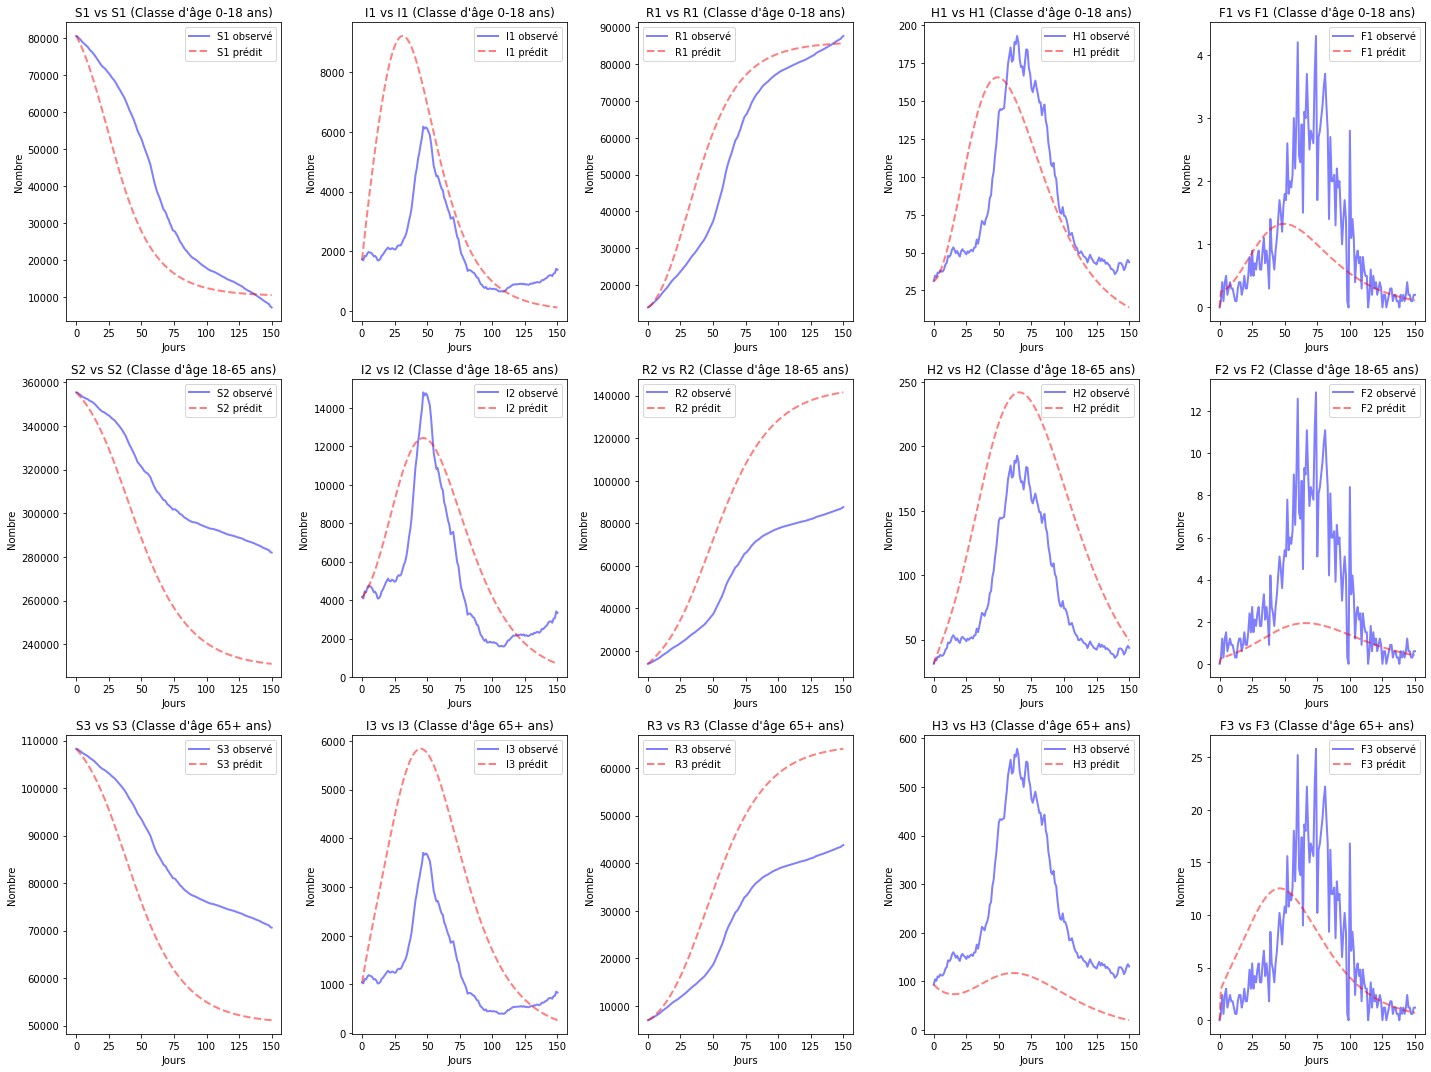

In [536]:
import matplotlib.pyplot as plt

components_age1 = ['S1', 'I1', 'R1', 'H1', 'F1']
components_age2 = ['S2', 'I2', 'R2', 'H2', 'F2']
components_age3 = ['S3', 'I3', 'R3', 'H3', 'F3']

# Fonction pour tracer chaque composant par rapport à lui-même pour chaque classe d'âge
def plot_components_vs_components(components_age1, components_age2, components_age3):
    plt.figure(figsize=(20, 15))
    
    # Tracer pour la première classe d'âge (0-18 ans)
    for i, (component1, component2) in enumerate(zip(components_age1, components_age1)):
        plt.subplot(3, len(components_age1), i+1)
        plt.plot(time, sir_data[component1], color='blue', alpha=0.5, lw=2, label=f'{component1} observé')
        plt.plot(time, sir_data1[component2], color='red', alpha=0.5, lw=2, linestyle='--', label=f'{component2} prédit')
        plt.title(f'{component1} vs {component2} (Classe d\'âge 0-18 ans)')
        plt.xlabel('Jours')
        plt.ylabel('Nombre')
        plt.legend()

    # Tracer pour la deuxième classe d'âge (18-65 ans)
    for i, (component1, component2) in enumerate(zip(components_age2, components_age2), len(components_age1)):
        plt.subplot(3, len(components_age2), i+1)
        plt.plot(time, sir_data[component1], color='blue', alpha=0.5, lw=2, label=f'{component1} observé')
        plt.plot(time, sir_data1[component2], color='red', alpha=0.5, lw=2, linestyle='--', label=f'{component2} prédit')
        plt.title(f'{component1} vs {component2} (Classe d\'âge 18-65 ans)')
        plt.xlabel('Jours')
        plt.ylabel('Nombre')
        plt.legend()

    # Tracer pour la troisième classe d'âge (65+ ans)
    for i, (component1, component2) in enumerate(zip(components_age3, components_age3), 2*len(components_age1)):
        plt.subplot(3, len(components_age3), i+1)
        plt.plot(time, sir_data[component1], color='blue', alpha=0.5, lw=2, label=f'{component1} observé')
        plt.plot(time, sir_data1[component2], color='red', alpha=0.5, lw=2, linestyle='--', label=f'{component2} prédit')
        plt.title(f'{component1} vs {component2} (Classe d\'âge 65+ ans)')
        plt.xlabel('Jours')
        plt.ylabel('Nombre')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Tracer chaque composant par rapport à lui-même pour chaque classe d'âge
plot_components_vs_components(components_age1, components_age2, components_age3)


## Les plots d'hospitalisations

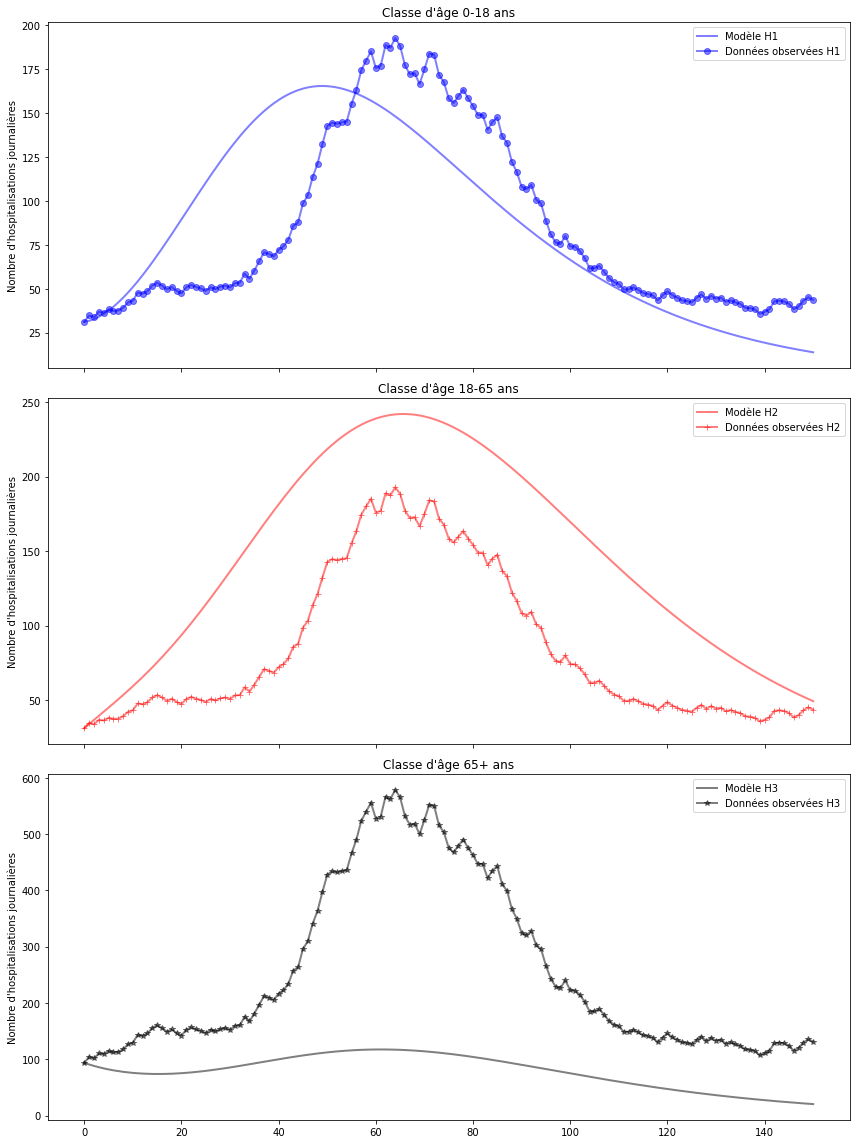

In [537]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(12, 16), sharex=True)

# Hospitalisations journalières H1 - Classe d'âge 0-18
axs[0].plot(time, sir_data1.H1, 'b', alpha=0.5, lw=2, label='Modèle H1')
axs[0].plot(time, sir_data.H1, 'b', alpha=0.5, lw=2, marker="o", label='Données observées H1')
axs[0].set_ylabel("Nombre d'hospitalisations journalières")
axs[0].set_title("Classe d'âge 0-18 ans")
axs[0].legend()

# Hospitalisations journalières H2 - Classe d'âge 18-65
axs[1].plot(time, sir_data1.H2, 'r', alpha=0.5, lw=2, label='Modèle H2')
axs[1].plot(time, sir_data.H2, 'r', alpha=0.5, lw=2, marker="+", label='Données observées H2')
axs[1].set_ylabel("Nombre d'hospitalisations journalières")
axs[1].set_title("Classe d'âge 18-65 ans")
axs[1].legend()

# Hospitalisations journalières H3 - Classe d'âge 65+
axs[2].plot(time, sir_data1.H3, 'black', alpha=0.5, lw=2, label='Modèle H3')
axs[2].plot(time, sir_data.H3, 'black', alpha=0.5, lw=2, marker="*", label='Données observées H3')
axs[2].set_ylabel("Nombre d'hospitalisations journalières")
axs[2].set_title("Classe d'âge 65+ ans")
axs[2].legend()

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage du graphique
plt.show()


## les plots de décés

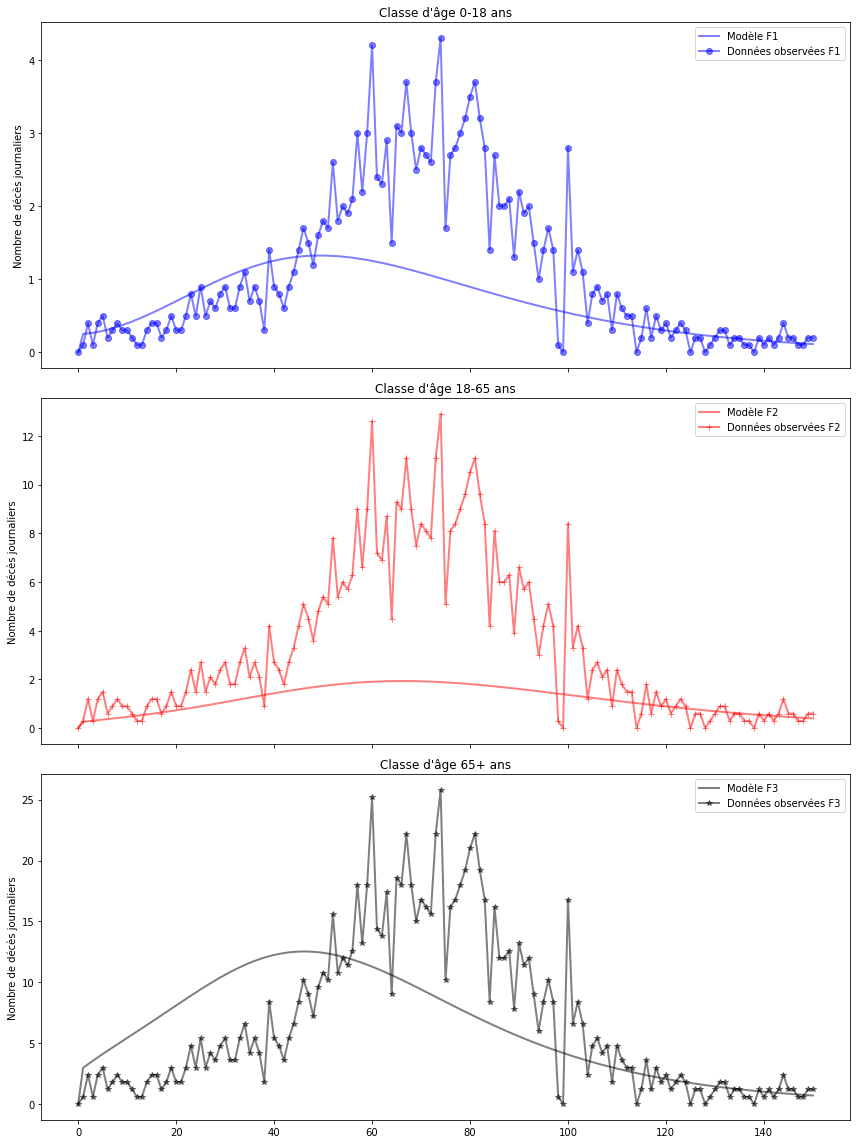

In [538]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(12, 16), sharex=True)

# Décès journaliers F1 - Classe d'âge 0-18
axs[0].plot(time, sir_data1.F1, 'b', alpha=0.5, lw=2, label='Modèle F1')
axs[0].plot(time, sir_data.F1, 'b', alpha=0.5, lw=2, marker="o", label='Données observées F1')
axs[0].set_ylabel("Nombre de décès journaliers")
axs[0].set_title("Classe d'âge 0-18 ans")
axs[0].legend()

# Décès journaliers F2 - Classe d'âge 18-65
axs[1].plot(time, sir_data1.F2, 'r', alpha=0.5, lw=2, label='Modèle F2')
axs[1].plot(time, sir_data.F2, 'r', alpha=0.5, lw=2, marker="+", label='Données observées F2')
axs[1].set_ylabel("Nombre de décès journaliers")
axs[1].set_title("Classe d'âge 18-65 ans")
axs[1].legend()

# Décès journaliers F3 - Classe d'âge 65+
axs[2].plot(time, sir_data1.F3, 'black', alpha=0.5, lw=2, label='Modèle F3')
axs[2].plot(time, sir_data.F3, 'black', alpha=0.5, lw=2, marker="*", label='Données observées F3')
axs[2].set_ylabel("Nombre de décès journaliers")
axs[2].set_title("Classe d'âge 65+ ans")
axs[2].legend()

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage du graphique
plt.show()


## les plots d'infections

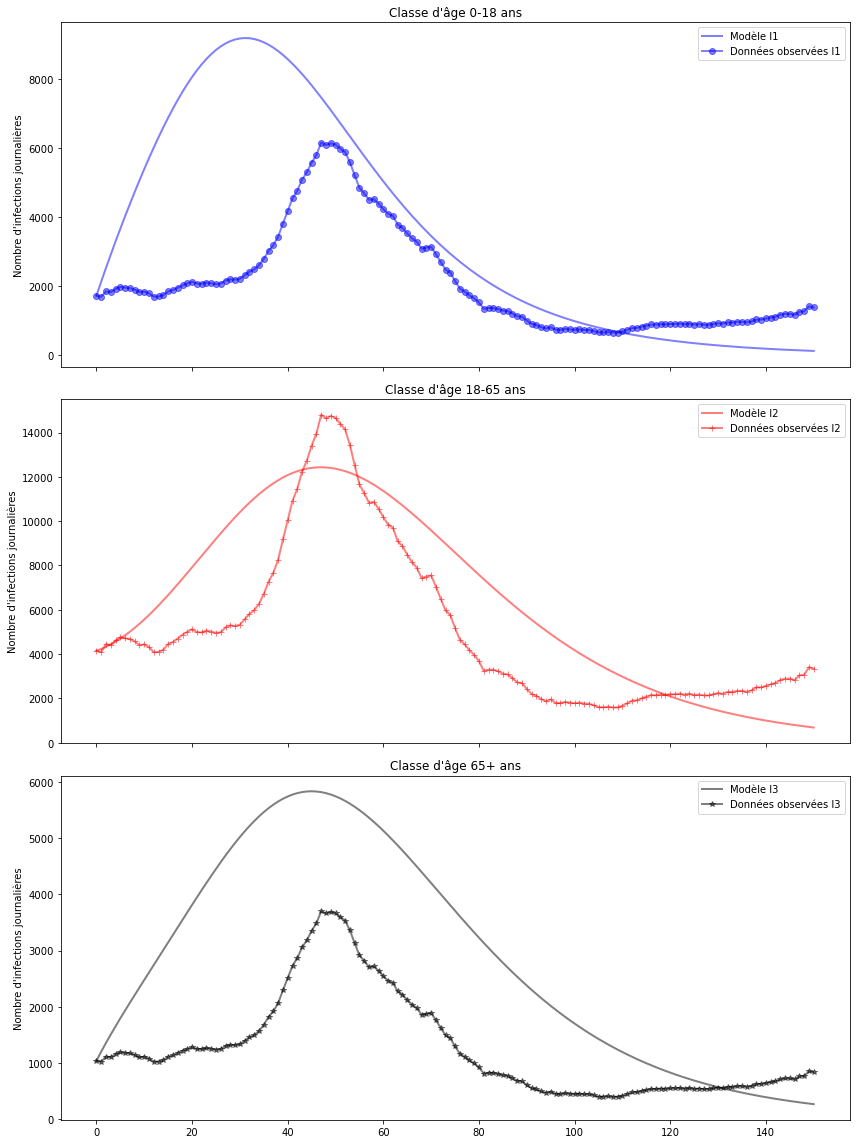

In [539]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(12, 16), sharex=True)

# Infections journalières I1 - Classe d'âge 0-18
axs[0].plot(time, sir_data1.I1, 'b', alpha=0.5, lw=2, label='Modèle I1')
axs[0].plot(time, sir_data.I1, 'b', alpha=0.5, lw=2, marker="o", label='Données observées I1')
axs[0].set_ylabel("Nombre d'infections journalières")
axs[0].set_title("Classe d'âge 0-18 ans")
axs[0].legend()

# Infections journalières I2 - Classe d'âge 18-65
axs[1].plot(time, sir_data1.I2, 'r', alpha=0.5, lw=2, label='Modèle I2')
axs[1].plot(time, sir_data.I2, 'r', alpha=0.5, lw=2, marker="+", label='Données observées I2')
axs[1].set_ylabel("Nombre d'infections journalières")
axs[1].set_title("Classe d'âge 18-65 ans")
axs[1].legend()

# Infections journalières I3 - Classe d'âge 65+
axs[2].plot(time, sir_data1.I3, 'black', alpha=0.5, lw=2, label='Modèle I3')
axs[2].plot(time, sir_data.I3, 'black', alpha=0.5, lw=2, marker="*", label='Données observées I3')
axs[2].set_ylabel("Nombre d'infections journalières")
axs[2].set_title("Classe d'âge 65+ ans")
axs[2].legend()

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage du graphique
plt.show()
